## Initializations and Dataset Download

In [1]:
import sys
from pathlib import Path

# Get the project root (assuming notebook is in a subfolder of the project)
notebook_dir = Path().resolve()
project_root = notebook_dir.parent  # Adjust .parent depth based on your structure

# Add to path if not already there
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

In [2]:
# !pip install opendatasets --quiet
# import opendatasets as od
# od.download("https://www.kaggle.com/datasets/mssmartypants/rice-type-classification")

## Imports

Lets start by getting all our imports, keep in mind that PyTorch is not automatically detects and trains on GPU, you have to tell it to use cuda. In case you want to train on Mac Silicon replace cuda with mps.

In [3]:
import torch
import torch.nn as nn
from torch.optim import Adam # Adam Optimizer
from torch.utils.data import Dataset, DataLoader # Dataset class and DataLoader for creatning the objects
from torchinfo import summary # Visualize the model layers and number of parameters

from sklearn.model_selection import train_test_split # Split the dataset (train, validation, test)
from sklearn.metrics import accuracy_score # Calculate the testing Accuracy
import matplotlib.pyplot as plt # Plotting the training progress at the end
import pandas as pd # Data reading and preprocessing
import numpy as np # Mathematical operations
import seaborn as sns

device = 'cuda' if torch.cuda.is_available() else 'cpu' # detect the GPU if any, if not use CPU, change cuda to mps if you have a mac
print(device)

cpu


## EDA & Preprocessing

Now lets read the dataset, this lab was developed by Google Colab, so dataset downloaded and read from the path shown below. We will be reading the dataset using pandas read_csv function, then we will remove the nulls/missing data from our dataframe as a filteration process, keep in mind that this process is essential as missing data will stop the code from training. You can skip dropping the missing values if you are 100% sure that there are no missing values in your data. Also, we dropped the id column because it will not affect our classification at all. We printed the output possibilities as we can see its a binary classification. We printed also the data shape (rows, columns) After that we printed the dataset shape and we used the head() function to visualize the first 5 rows, this step is optional as it just allows us to see the first 5 rows and will not affect the training process.

Now as you saw previously, data values are so big which may cause bad results. Its a crucial steps to normalize the dataset before we proceed. Lets normalize the dataset in the cell below.



In [4]:
# Read dataset
df = pd.read_csv("riceClassification.csv")
print("Dataset overview:")
display(df.head())

# Display dataset information
from utils import check_data_information
desc_df = check_data_information(df, df.columns)
print("Dataset information:")
print(f"Original data shape: {df.shape}")
display(desc_df)


Dataset overview:


,id,Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,EquivDiameter,Extent,Perimeter,Roundness,AspectRation,Class
0,1,4537,92.229316,64.012769,0.719916,4677,76.004525,0.657536,273.085,0.764510,1.440796,1
1,2,2872,74.691881,51.400454,0.725553,3015,60.471018,0.713009,208.317,0.831658,1.453137,1
2,3,3048,76.293164,52.043491,0.731211,3132,62.296341,0.759153,210.012,0.868434,1.465950,1
3,4,3073,77.033628,51.928487,0.738639,3157,62.551300,0.783529,210.657,0.870203,1.483456,1
4,5,3693,85.124785,56.374021,0.749282,3802,68.571668,0.769375,230.332,0.874743,1.510000,1


Dataset information:
Original data shape: (18185, 12)


,Feature,Data Type,Null Values,Null Percentage,Duplicated Values,Unique Values,Unique Sample
0,id,int64,0,0.0,0,18185,"1, 2, 3, 4, 5"
1,Area,int64,0,0.0,0,5343,"4537, 2872, 3048, 3073, 3693"
2,MajorAxisLength,float64,0,0.0,0,18185,"92.2293165, 74.69188071, 76.2931638, 77.033627..."
3,MinorAxisLength,float64,0,0.0,0,18185,"64.01276874, 51.40045446, 52.04349114, 51.9284..."
4,Eccentricity,float64,0,0.0,0,18185,"0.7199162256, 0.7255527468, 0.7312109273, 0.73..."
5,ConvexArea,int64,0,0.0,0,5450,"4677, 3015, 3132, 3157, 3802"
6,EquivDiameter,float64,0,0.0,0,5343,"76.00452496, 60.47101762, 62.29634124, 62.5512..."
7,Extent,float64,0,0.0,0,18007,"0.6575362319, 0.7130089374, 0.7591531756, 0.78..."
8,Perimeter,float64,0,0.0,0,16246,"273.085, 208.317, 210.012, 210.657, 230.332"
9,Roundness,float64,0,0.0,0,18184,"0.7645096145, 0.8316582009, 0.8684335737, 0.87..."


In [5]:
# Preprocessing steps
df = df.drop(columns=["id"]) # Dropping the id column since it doesn't contain important information

In [6]:
# Checking the distribution of the target variables
df["Class"].value_counts()

Class
1    9985
0    8200
Name: count, dtype: int64

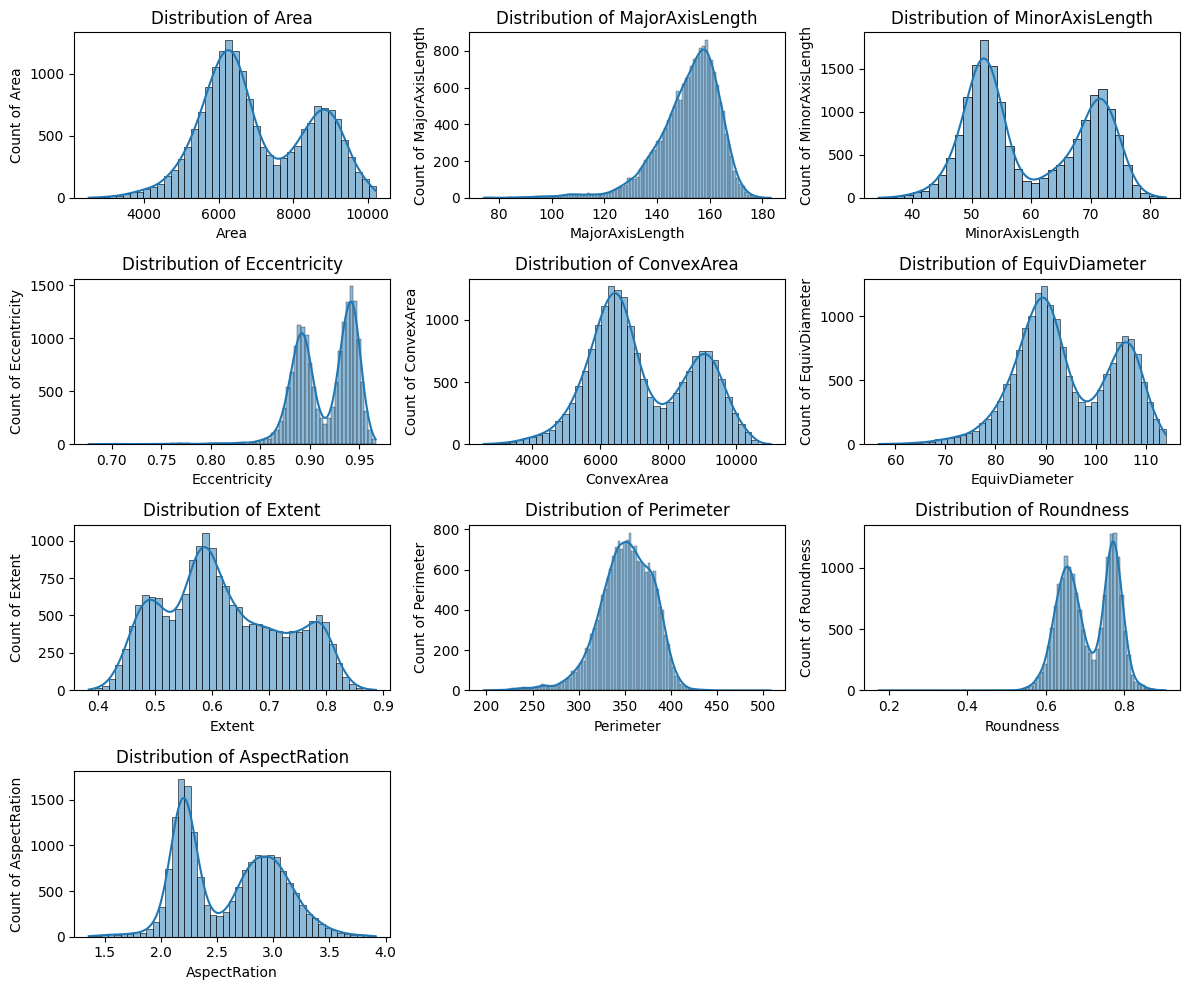

,Feature,overall_count,overall_mean,overall_std,overall_min,overall_25%,overall_50%,overall_75%,overall_max,overall_range,overall_IQR,overall_CV,overall_skewness,overall_kurtosis
0,Area,18185.0,7036.492989,1467.197150,2522.000000,5962.000000,6660.000000,8423.000000,10210.000000,7688.000000,2461.000000,20.851256,0.195594,-0.871609
1,MajorAxisLength,18185.0,151.680754,12.376402,74.133114,145.675910,153.883750,160.056214,183.211434,109.078320,14.380304,8.159507,-1.435412,3.845754
2,MinorAxisLength,18185.0,59.807851,10.061653,34.409894,51.393151,55.724288,70.156593,82.550762,48.140868,18.763442,16.823297,0.203084,-1.406644
3,Eccentricity,18185.0,0.915406,0.030575,0.676647,0.891617,0.923259,0.941372,0.966774,0.290127,0.049755,3.340061,-1.109837,3.772370
4,ConvexArea,18185.0,7225.817872,1502.006571,2579.000000,6125.000000,6843.000000,8645.000000,11008.000000,8429.000000,2520.000000,20.786665,0.202365,-0.866272
5,EquivDiameter,18185.0,94.132952,9.906250,56.666658,87.126656,92.085696,103.559146,114.016559,57.349901,16.432490,10.523680,-0.003633,-0.666257
6,Extent,18185.0,0.616653,0.104389,0.383239,0.538530,0.601194,0.695664,0.886573,0.503334,0.157135,16.928395,0.277214,-0.850320
7,Perimeter,18185.0,351.606949,29.500620,197.015000,333.990000,353.088000,373.003000,508.511000,311.496000,39.013000,8.390227,-0.655806,1.348106
8,Roundness,18185.0,0.707998,0.067310,0.174590,0.650962,0.701941,0.769280,0.904748,0.730158,0.118318,9.507107,-0.180811,-0.431796
9,AspectRation,18185.0,2.599081,0.434836,1.358128,2.208527,2.602966,2.964101,3.911845,2.553716,0.755574,16.730392,0.209437,-0.968168


In [7]:
# Checking the distribution and statistical summary of the values
from utils import describe_numerical_combined, plot_dynamic_hisplots_kdeplots

nums_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
nums_cols.remove('Class')  # Remove target column from numerical columns

# Hisplot function implementation
plot_dynamic_hisplots_kdeplots(df=df, col_series=nums_cols, ncols=3, figsize=(12, 10))

# Display the overall statistics for numerical columns
numerical_summary = describe_numerical_combined(df, nums_cols)
display(numerical_summary)

Amount of Rows: 18185
Amount of Outlier Rows (Across All Columns): 578
Amount of Non-Outlier Rows (Across All Columns): 17607
Percentage of Outliers: 3.18%



,Column Name,Outlier Exist,Lower Limit,Upper Limit,Outlier Data,Non-Outlier Data,Outlier Percentage (%)
0,Area,False,2270.500000,12114.500000,0,18185,0.00
1,MajorAxisLength,True,124.105454,181.626671,538,17647,2.96
2,MinorAxisLength,False,23.247988,98.301756,0,18185,0.00
3,Eccentricity,True,0.816984,1.016005,136,18049,0.75
4,ConvexArea,False,2345.000000,12425.000000,0,18185,0.00
5,EquivDiameter,True,62.477921,128.207881,16,18169,0.09
6,Extent,False,0.302828,0.931366,0,18185,0.00
7,Perimeter,True,275.470500,431.522500,315,17870,1.73
8,Roundness,True,0.473485,0.946757,14,18171,0.08
9,AspectRation,False,1.075166,4.097461,0,18185,0.00


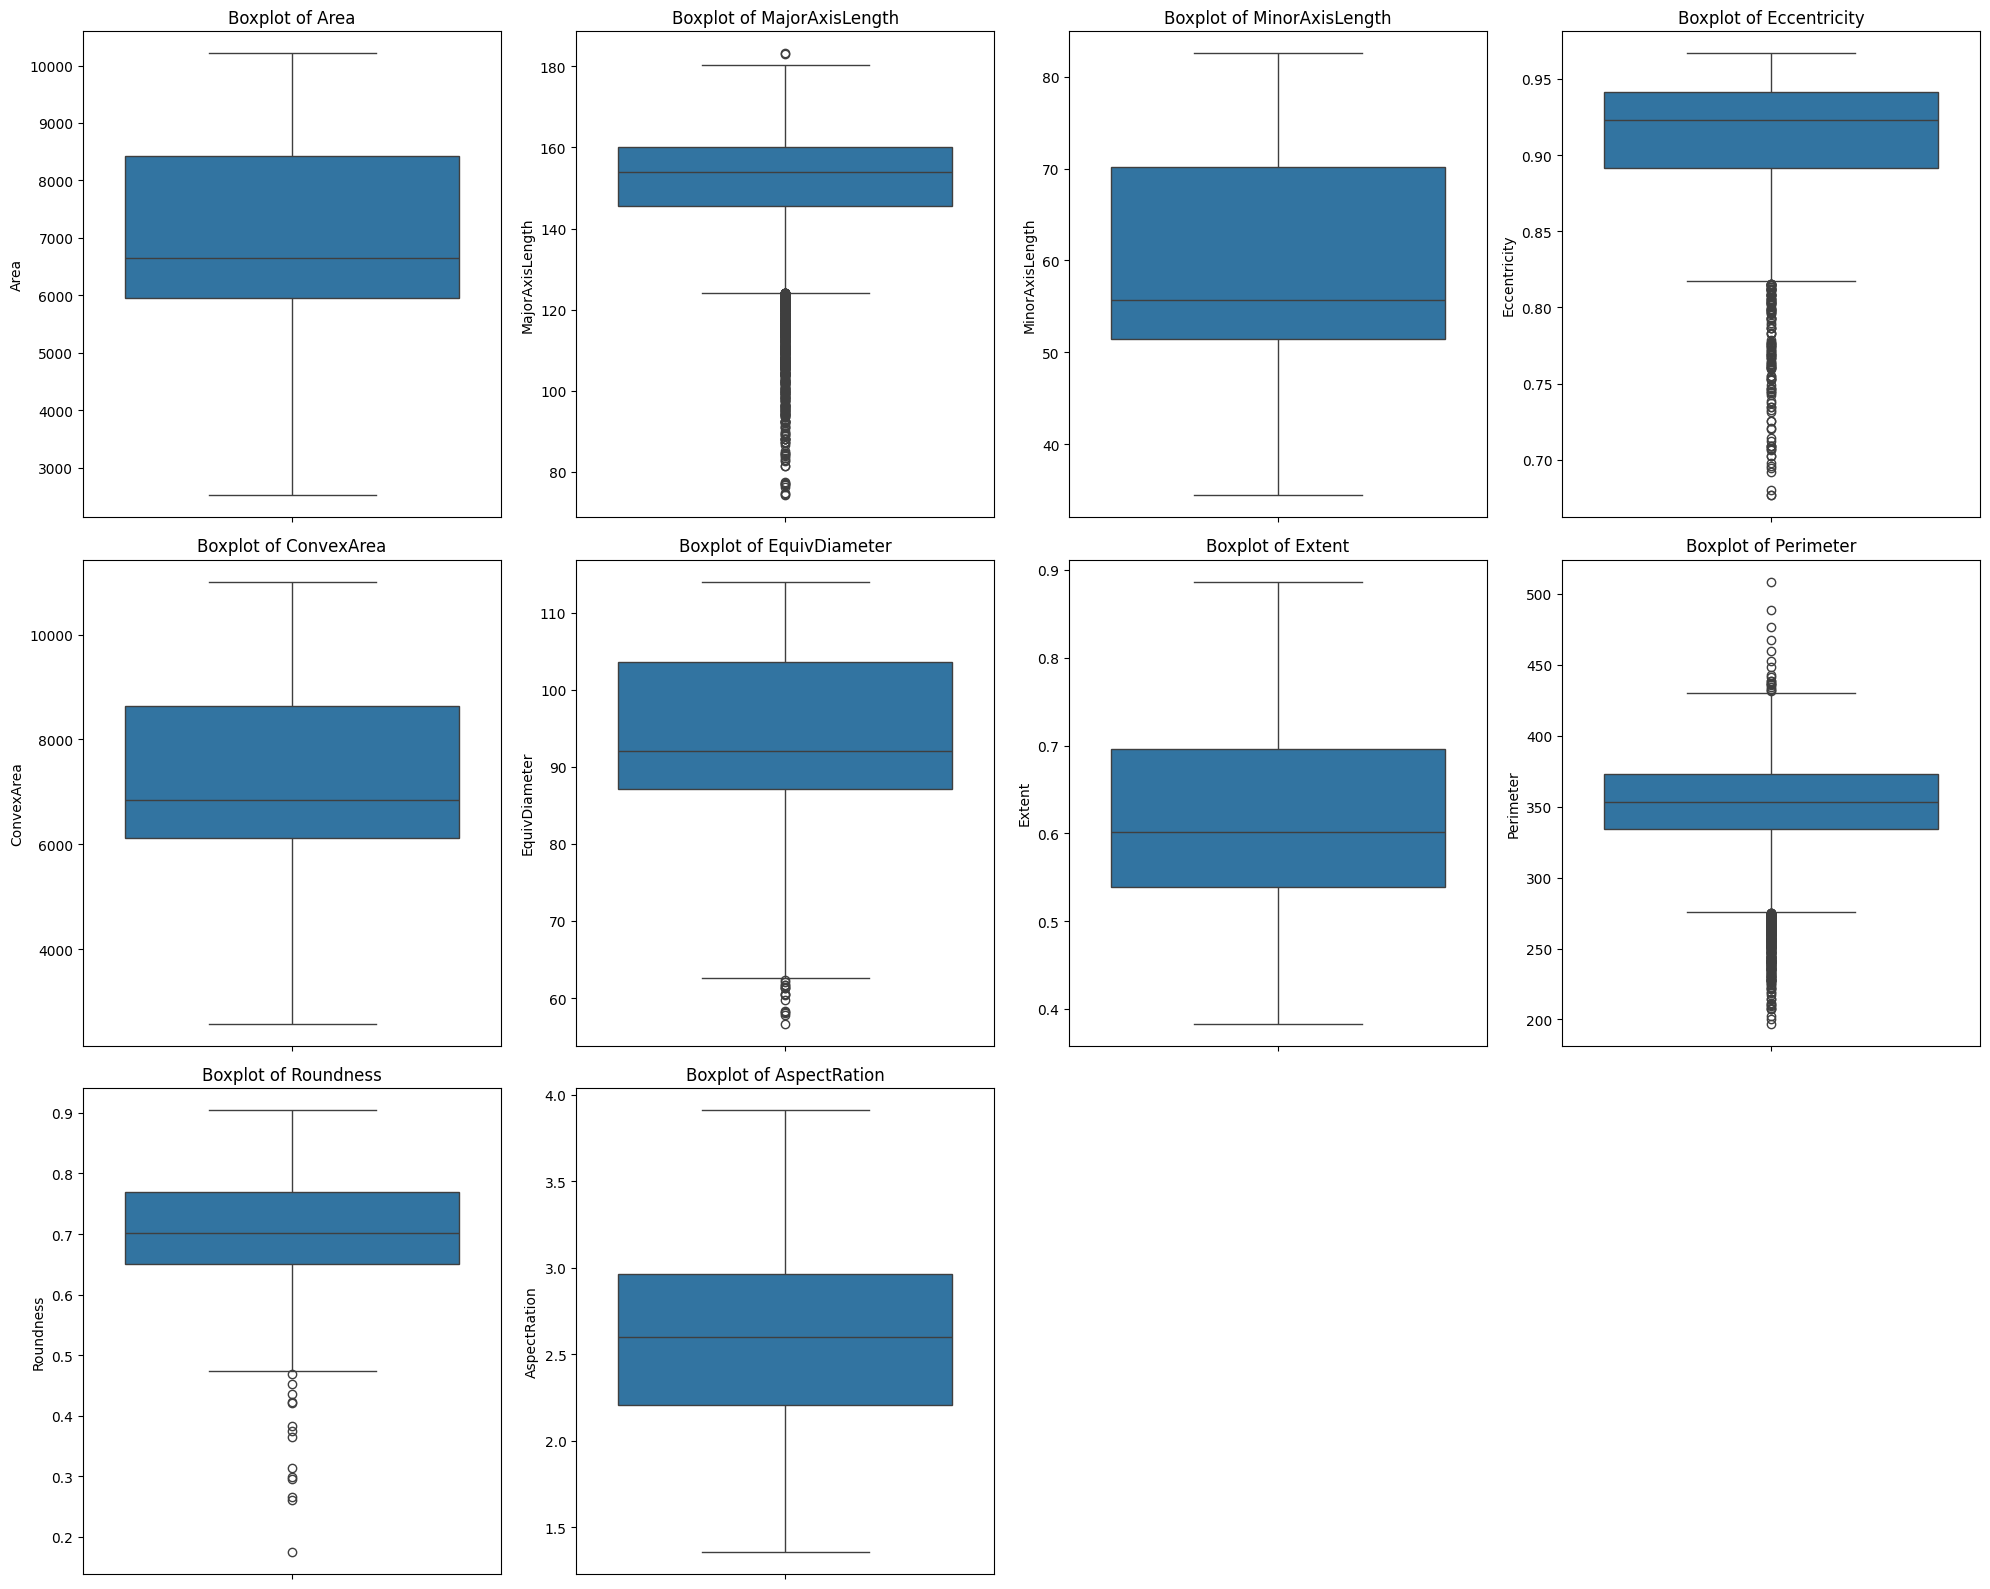

In [8]:
# Checking the outlier of the dataset
from utils import plot_dynamic_boxplots_violinplots, filter_outliers

# Check the outliers with IQR
summary = filter_outliers(df, columns=nums_cols, detect_only=True)
display(summary)

# Visualize the outliers
plot_dynamic_boxplots_violinplots(df, nums_cols, plot_type="boxplot", ncols=4, orientation="v", figsize=(20, 16))

In [9]:
# Implement the outliers handling
df_outlier_handle = filter_outliers(df, columns=nums_cols, method='iqr', threshold=1.5, detect_only=False)

In [10]:
# Feature scaling with standardization
from utils import feature_scaling

# Training data - fit new scaler
df_scaled, scaler = feature_scaling(
    df_outlier_handle, 
    columns=nums_cols,
    method='standard',  # or 'minmax', 'robust'
    apply_log=False
)

## Data Splitting

We will detect the inputs and the outputs of the data which are X and Y respectively.

Then we will split our data into the following:

- Training Size 70%
- Validation Size 15%
- Testing Size 15%

We will do this by splitting our data twice using the train_test_split function in sklearn the function takes inputs, outputs and the testing size. After that we will print the training, validation and testing shapes and sizes. Then we will print the new shapes of our data.

In [11]:
# Separate features and target
# X = df_scaled.drop(columns=["Class"])
# y = df_scaled["Class"]

## other way to do it
X = np.array(df_scaled.iloc[:, :-1]) # all rows, all columns except the last one
y = np.array(df_scaled.iloc[:, -1]) # all rows, only the last column

In [12]:
# Split the dataset into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Split the test dataset into test and validation
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

# Display the shapes of the datasets
print(f"Training set is: {X_train.shape[0]} rows which is {round(X_train.shape[0]/df_scaled.shape[0],4)*100}%") # Print training shape
print(f"Validation set is: {X_val.shape[0]} rows which is {round(X_val.shape[0]/df_scaled.shape[0],4)*100}%") # Print validation shape
print(f"Testing set is: {X_test.shape[0]} rows which is {round(X_test.shape[0]/df_scaled.shape[0],4)*100}%") # Print testing shape

Training set is: 12324 rows which is 69.99%
Validation set is: 2642 rows which is 15.010000000000002%
Testing set is: 2641 rows which is 15.0%


## Dataset Object

Now we will create the dataset object. This part is not complex but its a bit tricky. We need to convert our dataset to PyTorch Dataset object as it will be more efficient during training, you can use the dataset as its, but lets keep things professional and efficient. First we define our class that will be taking the main Dataset class with the concept of inheritance. Let's make the concept simpler. There is a big class that PyTorch, this class has several functions inside it, we will recreate that class and modify some functions to match our needs.

In the cell below, we rebuilt the constructor function which is __init__. We put X and Y as a parameters to this function which are the inputs and outputs respectively, then inside the function we define the inputs and converting it to tensors, then converting the outputs to tensors and we make the numbers as a float32 Additionally, we moved all our data to cuda device. Then we modified the __len__ and the __getitem__ to match our needs which gets the specific length/shape of the data, and the data of specific row in our data respectively.

In [13]:
# Create the dataset object
class dataset(Dataset):

    # Constructor function
    def __init__(self, X, y):
        # Convert to tensors (pytorch only takes tensors) and move to device
        self.X = torch.tensor(X, dtype=torch.float32).to(device) 
        self.y = torch.tensor(y, dtype=torch.float32).to(device) 
    
    # Get the length of the data
    def __len__(self):
        return len(self.X)

    # Get the data of specific index
    def __getitem__(self, index):
        return self.X[index], self.y[index]
    
# Create object for training, validation and testing
training_data = dataset(X_train, y_train)
validation_data = dataset(X_val, y_val)
testing_data = dataset(X_test, y_test)

## Training Hyper Parameters

Now we are setting the training hyperparameters, we defined some variables which are the batch size, number of training epochs, Hidden Neurons and learning rate.

In [14]:
BATCH_SIZE = 32
EPOCHS = 10
HIDDEN_NEURONS = 10
LR = 1e-3

## Data Loaders

This concept may seem complicated, but its very easy, PyTorch provides a class called DataLoader which allows us to create objects of it to simplify the training.

Dataloader is an object that we can loop through it to train according to batches. When we start training, we loop through epochs, if you skip the batch size it means that the amount of training data in one batch is equal to the complete amount of training data, this method is not efficient and in most of the cases you need to train through using batches. Dataloader allows you to loop through the batches easily during the training. When you create a dataloader. You define the batch size and enable the shuffle to randomize the data and then you can loop through it in each epoch to train normally.

In the next cell, we defined a dataloader for each of our data (training, validation and testing).

In [15]:
## A dataloader is a class that loads the data in batches. 
## It basically an object that we use to do the for loop during each epoch.

# Create DataLoader objects
training_dataloader = DataLoader(training_data, batch_size=BATCH_SIZE, shuffle=True)
validation_dataloader = DataLoader(validation_data, batch_size=BATCH_SIZE, shuffle=True)
testing_dataloader = DataLoader(testing_data, batch_size=BATCH_SIZE, shuffle=True)

In [16]:
# Example of what the dataloader object looks like

# The dataloader returns batches of data in each iteration
# 'batch' contains the input features (X) for multiple samples
# 'label' contains the corresponding target values (y) for those samples
# Notice that each run of the for loop will return a different batch of data

for batch, label in training_dataloader:
    print(batch.shape)  # Print the batch of input features (shape: [batch_size, num_features])
    print(batch)  # Print the batch of input features (shape: [batch_size, num_features])
    
    print("="*100)

    print(label.shape)  # Print the batch of labels/targets (shape: [batch_size])
    print(label)  # Print the batch of labels/targets (shape: [batch_size])
    break  # Only show one batch as an example

torch.Size([32, 10])
tensor([[ 1.0596e+00,  3.6896e-01,  1.0839e+00, -9.2719e-01,  1.0582e+00,
          1.0628e+00,  5.2601e-01,  7.6141e-01,  1.0523e+00, -9.5016e-01],
        [ 1.0143e+00,  6.3436e-02,  1.2197e+00, -1.2667e+00,  1.0554e+00,
          1.0214e+00, -1.7845e-01,  9.3694e-01,  6.8521e-01, -1.1474e+00],
        [-1.1025e+00, -1.9876e+00, -5.0163e-01, -2.2872e-01, -1.1270e+00,
         -1.1258e+00, -8.6804e-01, -1.6450e+00,  1.9342e-01, -4.4924e-01],
        [-2.1840e-01,  1.0879e+00, -6.0114e-01,  9.9129e-01, -2.3370e-01,
         -1.7211e-01, -1.3531e+00,  4.2278e-01, -9.7653e-01,  9.9119e-01],
        [ 1.2102e+00,  6.0574e-01,  1.1389e+00, -8.6728e-01,  1.1715e+00,
          1.1995e+00, -4.3134e-01,  8.3568e-01,  1.2215e+00, -9.1264e-01],
        [-5.2110e-01,  7.2317e-01, -7.9351e-01,  1.0494e+00, -4.6306e-01,
         -4.8795e-01,  3.8022e-04,  2.6164e-01, -1.3801e+00,  1.0918e+00],
        [ 3.0355e-01, -9.2866e-01,  7.7628e-01, -1.2932e+00,  2.7752e-01,
          3

## Model Class

Creating a model in PyTorch seems not very straight forward in the beggining, but if you understand how machine learning and deep learning works, it will be easy for you to understand PyTorch structure easily.

In the next cell we define a new class MyModel that inherits from nn.Module like we did for the dataset. Remember, in simple terms, we want to redefine some functions in the class to match our needs. In the constructor which is __init__ and we give it the bert model. Then super(MyModel, self).__init__() This line calls the constructor of the parent class nn.Module to ensure it's properly initialized. Which means we have the original constructor together with our part of it!

Then, we create our layers, a linear layer which represents the input and having the input size of 10 which is the number of columns of the input and the output of the number of hidden neurons, next layer is the output layer which have the input of hidden neurons and one output since we have a binary classification. Finally we have the activation function which is the sigmoid. Our model is pretty simple and straight forward, we are using a simple dataset and we just want to see how PyTorch can be used to build that.

In the function forward, this function is the forward propagation of the model, how is the data flowing inside the model from the input to the output. This means we can control this completely. That's how PyTorch is so customizable! In the below cell, we define the flow as follows, starting by input layer and followed by the output layer then the activation layer.

In [17]:
class MyModel(nn.Module):
    def __init__(self):
        # Call the parent class (nn.Module) constructor
        # This initializes all the PyTorch machinery needed for your model
        super(MyModel, self).__init__()

        # First layer: takes input features and transforms them to hidden neurons
        # X.shape[1] = number of input features (10 in your case)
        # HIDDEN_NEURONS = number of neurons in the hidden layer
        # This layer learns weights and biases: output = input @ weights + bias
        self.input_layer = nn.Linear(X.shape[1], HIDDEN_NEURONS)
        
        # Second layer: takes hidden neurons and outputs a single value
        # HIDDEN_NEURONS = input size (from previous layer)
        # 1 = output size (single value for binary classification)
        self.linear = nn.Linear(HIDDEN_NEURONS, 1)
        
        # Activation function: squashes output to range [0, 1]
        # This converts the raw output into a probability
        # Values close to 0 = class 0, values close to 1 = class 1
        self.sigmoid = nn.Sigmoid()
        
        # Other activation function options for binary classification:
        # self.tanh = nn.Tanh()  # Output range [-1, 1], good for hidden layers
        # self.relu = nn.ReLU()  # Output range [0, inf), most popular for hidden layers, prevents vanishing gradient
        # self.leaky_relu = nn.LeakyReLU()  # Like ReLU but allows small negative values, prevents dying neurons
        # self.elu = nn.ELU()  # Exponential Linear Unit, smoother than ReLU, can output negative values
        # self.softmax = nn.Softmax(dim=1)  # For multi-class classification (converts to probability distribution)
        # Note: For binary classification with BCELoss, Sigmoid is the standard choice for output layer
        # For hidden layers, ReLU or LeakyReLU are typically better choices

    def forward(self, x):
        # Define how data flows through the network (forward pass)
        # x starts as your input data (batch of samples with 10 features each)
        
        # Pass through first layer: transforms input features to hidden representation
        x = self.input_layer(x)
        
        # Pass through second layer: transforms hidden representation to single output value
        x = self.linear(x)
        
        # Apply sigmoid activation: converts output to probability between 0 and 1
        x = self.sigmoid(x)
        
        # Return the final prediction (probability of being class 1)
        return x

## Model Creation

Now lets create our model and move it to the assigned device (cuda if you have GPU or the CPU if you don't have any GPUs). Additionally, we will print the a summary of the model using the function summary which will take our model and the input size.

In [19]:
# Instantiate the neural network model
# MyModel() creates a new instance of our custom neural network class
# .to(device) moves the model to the appropriate device (GPU if available, otherwise CPU)
# This ensures all model parameters and computations happen on the correct hardware
model = MyModel().to(device)

# Display a summary of the model architecture
# torchinfo.summary() prints layer-by-layer details including:
# - Layer types and names
# - Output shapes at each layer
# - Number of trainable parameters (weights and biases)
# input_size specifies the input shape: a tuple with (batch_size, num_features)
# This helps verify the model structure and parameter count before training
from torchinfo import summary as model_summary
model_summary(model, input_size=(1, X.shape[1]))

Layer (type:depth-idx)                   Output Shape              Param #
MyModel                                  [1, 1]                    --
├─Linear: 1-1                            [1, 10]                   110
├─Linear: 1-2                            [1, 1]                    11
├─Sigmoid: 1-3                           [1, 1]                    --
Total params: 121
Trainable params: 121
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.00
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00

## Loss and Optimizer

In the next cell, we will create the loss function which will be Binary Cross entropy and the optimizer Adam which will take the model parameters/weights and the learning rate.

In [ ]:
# Define the loss function for binary classification
# BCELoss (Binary Cross Entropy Loss) measures how far predictions are from actual labels
# Perfect for binary classification problems (0 or 1 outputs)
# Other options:
# - nn.BCEWithLogitsLoss() - combines sigmoid + BCE, more numerically stable (recommended if not using sigmoid in model)
# - nn.CrossEntropyLoss() - for multi-class classification
# - nn.MSELoss() - for regression problems
criterion = nn.BCELoss()

# Define the optimizer to update model weights during training
# Adam (Adaptive Moment Estimation) adjusts learning rates automatically for each parameter
# model.parameters() gives all trainable weights/biases to optimize
# lr (learning rate) controls how big the weight updates are each step
# Other optimizer options:
# - torch.optim.SGD() - basic stochastic gradient descent, simpler but may need tuning
# - torch.optim.AdamW() - Adam with weight decay, better generalization
# - torch.optim.RMSprop() - good for RNNs
# - torch.optim.Adagrad() - adapts learning rate based on parameter frequency
optimizer = Adam(model.parameters(), lr=LR)

## Training

## Testing

## Plotting and Visualizations (Optional)

## Inference